In [1]:
import qutip as qt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time
import pickle

from scipy import optimize
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.linalg import sqrtm

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#### parallelization 
options = qt.Options(num_cpus=6)



In [2]:

### Setup matplotlib

plt.rcParams.update({
    "text.usetex": True,
    "mathtext.fontset" : "stix",
    #"font.family" : "Times New Roman", 
    "text.latex.preamble": r"\usepackage[T1]{fontenc} \usepackage{bbm} \usepackage{lmodern} \usepackage{amsmath} \usepackage{amstext}  \usepackage{amsfonts}",
    #
    "savefig.dpi" : 300,
    "xtick.minor.visible": True, 
    "ytick.minor.visible": True,
    
    "ytick.right": True,
    "ytick.left": True,

    "xtick.top": True,
    "xtick.bottom": True,
 
    #
    "xtick.direction": "in",
    "ytick.direction": "in",
    #
    "xtick.major.width": 1.5,     # major tick width in points
    "ytick.major.width": 1.5,     # major tick width in points
    #
    "xtick.minor.width": 1.5,     # minor tick width in points
    "ytick.minor.width": 1.5,     # minor tick width in points
    #
    "xtick.major.pad": 3.0,     # distance to major tick label in points
    "ytick.major.pad": 3.0,     # distance to major tick label in points
    #
    "xtick.minor.pad": 1.5,     # distance to the minor tick label in points
    "ytick.minor.pad": 1.5,     # distance to the minor tick label in points
    #
    "xtick.major.size": 3.0, 
    "ytick.major.size": 3.0,
    
    "xtick.minor.size": 3.0, 
    "ytick.minor.size": 3.0,
    #
    "xtick.labelsize": 20, 
    "ytick.labelsize": 20,
    #
    "legend.frameon": True, 
    "legend.fontsize": 20, 
    "legend.edgecolor": "black",
    "axes.titlesize": 20, 
    "axes.titleweight": "bold",
    "axes.labelsize":20 
})

##############
####### 
### Functions for evaluating the dominant eigenvalue

In [3]:

def Get_maximum(vector):
    """
    This function returns the maximum value and the corresponding index in a given vector.
    
    Parameters:
    vector: array-like 
        Input vector to search for the maximum value. 
    
    Returns: 
    max_value: float
        Maximum value found in the input vector.
    aux_idx: int
        Index of the maximum value in the input vector.
    """
    
    # Initialize variables for index and maximum value
    aux_idx = 0
    max_value = -np.Infinity
    
    # Enumerate through the vector, checking each value
    for idx, value in enumerate(vector):
        
        # If the current maximum value is greater than the real part of the current value
        if np.real(max_value) < np.real(value): 
            
            # Update the maximum value and the corresponding index
            max_value = value
            aux_idx = idx
            
    # Return the maximum value and its index
    return max_value, aux_idx



def Numeric_diagonalization(Ws, side="left"):
    """
    This function performs the numeric diagonalization of a given matrix, 
    returning the maximum eigenvalue and the corresponding eigenvector.

    Parameters:
    Ws: array-like
        Matrix to be diagonalized. 

    Returns:
    e_values[idx]: float
        Dominant (maximum) eigenvalue of the matrix.
    e_rightvectors[idx]: array-like
        Eigenvector corresponding to the dominant eigenvalue.
    """
    # Calculate the eigenvalues and left eigenvectors of the transpose of the input matrix
    if side == "left":
        e_values, e_vectors = np.linalg.eig(np.conjugate(Ws).T)
        # Get the maximum eigenvalue and its corresponding index
        dominant_e, idx = Get_maximum(e_values)

        # Get dimension
        d = int(np.sqrt(np.shape(Ws)[0]))
    
        # reshaping the result
        e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
        # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
        return e_values[idx], np.conjugate(e_mat)
    elif side == "right":
        e_values, e_vectors = np.linalg.eig(Ws)
        # Get the maximum eigenvalue and its corresponding index
        dominant_e, idx = Get_maximum(e_values)

        # Get dimension
        d = int(np.sqrt(np.shape(Ws)[0]))
    
        # reshaping the result
        e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
        # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
        return e_values[idx], e_mat/np.trace(e_mat)
        
    else: raise ValueError('You have to choose or left or right')

###############
####### Coding 
###############

In [4]:
  
# Define the states
ket00 = qt.tensor(qt.basis(2,1), qt.basis(2,1))
ket01 = qt.tensor(qt.basis(2,1), qt.basis(2,0))
ket10 = qt.tensor(qt.basis(2,0), qt.basis(2,1))
ket11 = qt.tensor(qt.basis(2,0), qt.basis(2,0))

sigmam_h = qt.tensor(qt.sigmam(), qt.qeye(2))
sigmam_c = qt.tensor(qt.qeye(2), qt.sigmam())
sigmap_h = qt.tensor(qt.sigmap(), qt.qeye(2))
sigmap_c = qt.tensor(qt.qeye(2), qt.sigmap())

sigmax_h = qt.tensor(qt.sigmax(), qt.qeye(2))
sigmax_c = qt.tensor(qt.qeye(2), qt.sigmax())

sigmaz_h = qt.tensor(qt.sigmaz(), qt.qeye(2))
sigmaz_c = qt.tensor(qt.qeye(2), qt.sigmaz())

eps0 = ket00
eps1 = np.sqrt(1/2)*(ket01 - ket10)
eps2 = np.sqrt(1/2)*(ket01 + ket10)
eps3 = ket11
    

def Tilted_lindbladian(t, args):

    s = args["s"]
    
    tau = args["tau"]

    # Define the parameters
    alpha_h = args["alpha_h"]
    alpha_c = args["alpha_c"]
    beta_h = args["beta_h"]/(1 + 0.5*np.sin(t*np.pi/tau)**2)
    beta_c = args["beta_c"]
     
    omega = args["omega"]  
    Omega = args["Omega"]
  
    g = args["g"]#*((t/tau)**2)

    ##### Define the Hamiltonian
    
    H0 = (Omega*( sigmam_h*sigmap_c + sigmap_h*sigmam_c) 
          + g*(sigmax_c + sigmax_h)
          + (omega/2)*(sigmaz_c + sigmaz_h))
    
    #H0 = 2*omega* (eps3*eps3.dag()) + (omega + Omega)*(eps2*eps2.dag()) + (omega - Omega)*(eps1*eps1.dag())

    ##### Define the jump operators

    ## Hot bath
    J_01_h = np.sqrt(alpha_h * (omega - Omega) ** 3 * (1 + 1 / (np.exp(beta_h * (omega - Omega)) - 1))) * (eps0 * eps1.dag())
    J_10_h = np.sqrt(alpha_h * (omega - Omega) ** 3 * (0 + 1 / (np.exp(beta_h * (omega - Omega)) - 1))) * (eps1 * eps0.dag())
    
    J_02_h = np.sqrt(alpha_h * (omega + Omega) ** 3 * (1 + 1 / (np.exp(beta_h * (omega + Omega)) - 1))) * (eps0 * eps2.dag())
    J_20_h = np.sqrt(alpha_h * (omega + Omega) ** 3 * (0 + 1 / (np.exp(beta_h * (omega + Omega)) - 1))) * (eps2 * eps0.dag())
    
    J_13_h = np.sqrt(alpha_h * (omega + Omega) ** 3 * (1 + 1 / (np.exp(beta_h * (omega + Omega)) - 1))) * (eps1 * eps3.dag())
    J_31_h = np.sqrt(alpha_h * (omega + Omega) ** 3 * (0 + 1 / (np.exp(beta_h * (omega + Omega)) - 1))) * (eps3 * eps1.dag())
    
    J_23_h = np.sqrt(alpha_h * (omega - Omega) ** 3 * (1 + 1 / (np.exp(beta_h * (omega - Omega)) - 1))) * (eps2 * eps3.dag())
    J_32_h = np.sqrt(alpha_h * (omega - Omega) ** 3 * (0 + 1 / (np.exp(beta_h * (omega - Omega)) - 1))) * (eps3 * eps2.dag())
   
    ## Cold bath
    J_01_c = np.sqrt(alpha_c * (omega - Omega) ** 3 * (1 + 1 / (np.exp(beta_c * (omega - Omega)) - 1))) * (eps0 * eps1.dag())
    J_10_c = np.sqrt(alpha_c * (omega - Omega) ** 3 * (0 + 1 / (np.exp(beta_c * (omega - Omega)) - 1))) * (eps1 * eps0.dag())
    
    J_02_c = np.sqrt(alpha_c * (omega + Omega) ** 3 * (1 + 1 / (np.exp(beta_c * (omega + Omega)) - 1))) * (eps0 * eps2.dag())
    J_20_c = np.sqrt(alpha_c * (omega + Omega) ** 3 * (0 + 1 / (np.exp(beta_c * (omega + Omega)) - 1))) * (eps2 * eps0.dag())
    
    J_13_c = np.sqrt(alpha_c * (omega + Omega) ** 3 * (1 + 1 / (np.exp(beta_c * (omega + Omega)) - 1))) * (eps1 * eps3.dag())
    J_31_c = np.sqrt(alpha_c * (omega + Omega) ** 3 * (0 + 1 / (np.exp(beta_c * (omega + Omega)) - 1))) * (eps3 * eps1.dag())
    
    J_23_c = np.sqrt(alpha_c * (omega - Omega) ** 3 * (1 + 1 / (np.exp(beta_c * (omega - Omega)) - 1))) * (eps2 * eps3.dag())
    J_32_c = np.sqrt(alpha_c * (omega - Omega) ** 3 * (0 + 1 / (np.exp(beta_c * (omega - Omega)) - 1))) * (eps3 * eps2.dag())

    ########### Flatenning the operators 
    Ide = qt.tensor(qt.qeye(2), qt.qeye(2))

    Flat_H0  = -1.0j*(qt.tensor(Ide, H0) - qt.tensor(H0.trans(), Ide)).full()

    ####### Non-hermitian evolution 
    ## hot bath
    Flat_J_01_h = -(1.0/2.0)*(qt.tensor(Ide, J_01_h.dag()*J_01_h) + qt.tensor((J_01_h.dag()*J_01_h).trans(), Ide)).full()
    Flat_J_02_h = -(1.0/2.0)*(qt.tensor(Ide, J_02_h.dag()*J_02_h) + qt.tensor((J_02_h.dag()*J_02_h).trans(), Ide)).full()
    Flat_J_13_h = -(1.0/2.0)*(qt.tensor(Ide, J_13_h.dag()*J_13_h) + qt.tensor((J_13_h.dag()*J_13_h).trans(), Ide)).full()
    Flat_J_23_h = -(1.0/2.0)*(qt.tensor(Ide, J_23_h.dag()*J_23_h) + qt.tensor((J_23_h.dag()*J_23_h).trans(), Ide)).full()

    Flat_J_10_h = -(1.0/2.0)*(qt.tensor(Ide, J_10_h.dag()*J_10_h) + qt.tensor((J_10_h.dag()*J_10_h).trans(), Ide)).full()
    Flat_J_20_h = -(1.0/2.0)*(qt.tensor(Ide, J_20_h.dag()*J_20_h) + qt.tensor((J_20_h.dag()*J_20_h).trans(), Ide)).full()
    Flat_J_31_h = -(1.0/2.0)*(qt.tensor(Ide, J_31_h.dag()*J_31_h) + qt.tensor((J_31_h.dag()*J_31_h).trans(), Ide)).full()
    Flat_J_32_h = -(1.0/2.0)*(qt.tensor(Ide, J_32_h.dag()*J_32_h) + qt.tensor((J_32_h.dag()*J_32_h).trans(), Ide)).full()

    ## cold bath
    Flat_J_01_c = -(1.0/2.0)*(qt.tensor(Ide, J_01_c.dag()*J_01_c) + qt.tensor((J_01_c.dag()*J_01_c).trans(), Ide)).full()
    Flat_J_02_c = -(1.0/2.0)*(qt.tensor(Ide, J_02_c.dag()*J_02_c) + qt.tensor((J_02_c.dag()*J_02_c).trans(), Ide)).full()
    Flat_J_13_c = -(1.0/2.0)*(qt.tensor(Ide, J_13_c.dag()*J_13_c) + qt.tensor((J_13_c.dag()*J_13_c).trans(), Ide)).full()
    Flat_J_23_c = -(1.0/2.0)*(qt.tensor(Ide, J_23_c.dag()*J_23_c) + qt.tensor((J_23_c.dag()*J_23_c).trans(), Ide)).full()

    Flat_J_10_c = -(1.0/2.0)*(qt.tensor(Ide, J_10_c.dag()*J_10_c) + qt.tensor((J_10_c.dag()*J_10_c).trans(), Ide)).full()
    Flat_J_20_c = -(1.0/2.0)*(qt.tensor(Ide, J_20_c.dag()*J_20_c) + qt.tensor((J_20_c.dag()*J_20_c).trans(), Ide)).full()
    Flat_J_31_c = -(1.0/2.0)*(qt.tensor(Ide, J_31_c.dag()*J_31_c) + qt.tensor((J_31_c.dag()*J_31_c).trans(), Ide)).full()
    Flat_J_32_c = -(1.0/2.0)*(qt.tensor(Ide, J_32_c.dag()*J_32_c) + qt.tensor((J_32_c.dag()*J_32_c).trans(), Ide)).full()

    Flat_Inc_h = (Flat_J_01_h + Flat_J_02_h + Flat_J_13_h + Flat_J_23_h
                + Flat_J_10_h + Flat_J_20_h + Flat_J_31_h + Flat_J_32_h)

    Flat_Inc_c = (Flat_J_01_c + Flat_J_02_c + Flat_J_13_c + Flat_J_23_c
                + Flat_J_10_c + Flat_J_20_c + Flat_J_31_c + Flat_J_32_c)

    ####### Jumps 
    # hot bath
    Flat_jump_J_01_h = (qt.tensor(J_01_h.conj(),J_01_h)).full()
    Flat_jump_J_02_h = (qt.tensor(J_02_h.conj(),J_02_h)).full()
    Flat_jump_J_13_h = (qt.tensor(J_13_h.conj(),J_13_h)).full()
    Flat_jump_J_23_h = (qt.tensor(J_23_h.conj(),J_23_h)).full()

    Flat_jump_J_10_h = (qt.tensor(J_10_h.conj(),J_10_h)).full()
    Flat_jump_J_20_h = (qt.tensor(J_20_h.conj(),J_20_h)).full()
    Flat_jump_J_31_h = (qt.tensor(J_31_h.conj(),J_31_h)).full()
    Flat_jump_J_32_h = (qt.tensor(J_32_h.conj(),J_32_h)).full()
    
    #cold bath
    Flat_jump_J_01_c = (qt.tensor(J_01_c.conj(),J_01_c)).full()
    Flat_jump_J_02_c = (qt.tensor(J_02_c.conj(),J_02_c)).full()
    Flat_jump_J_13_c = (qt.tensor(J_13_c.conj(),J_13_c)).full()
    Flat_jump_J_23_c = (qt.tensor(J_23_c.conj(),J_23_c)).full()

    Flat_jump_J_10_c = (qt.tensor(J_10_c.conj(),J_10_c)).full()
    Flat_jump_J_20_c = (qt.tensor(J_20_c.conj(),J_20_c)).full()
    Flat_jump_J_31_c = (qt.tensor(J_31_c.conj(),J_31_c)).full()
    Flat_jump_J_32_c = (qt.tensor(J_32_c.conj(),J_32_c)).full()

    Flat_Jump_h = (  np.exp(+s*(omega-Omega)*beta_h)*Flat_jump_J_01_h 
                   + np.exp(+s*(omega+Omega)*beta_h)*Flat_jump_J_02_h 
                   + np.exp(+s*(omega+Omega)*beta_h)*Flat_jump_J_13_h 
                   + np.exp(+s*(omega-Omega)*beta_h)*Flat_jump_J_23_h

                   + np.exp(-s*(omega-Omega)*beta_h)*Flat_jump_J_10_h 
                   + np.exp(-s*(omega+Omega)*beta_h)*Flat_jump_J_20_h 
                   + np.exp(-s*(omega+Omega)*beta_h)*Flat_jump_J_31_h 
                   + np.exp(-s*(omega-Omega)*beta_h)*Flat_jump_J_32_h)

    Flat_Jump_c = (  np.exp(+s*(omega-Omega)*beta_c)*Flat_jump_J_01_c 
                   + np.exp(+s*(omega+Omega)*beta_c)*Flat_jump_J_02_c 
                   + np.exp(+s*(omega+Omega)*beta_c)*Flat_jump_J_13_c 
                   + np.exp(+s*(omega-Omega)*beta_c)*Flat_jump_J_23_c

                   + np.exp(-s*(omega-Omega)*beta_c)*Flat_jump_J_10_c 
                   + np.exp(-s*(omega+Omega)*beta_c)*Flat_jump_J_20_c 
                   + np.exp(-s*(omega+Omega)*beta_c)*Flat_jump_J_31_c 
                   + np.exp(-s*(omega-Omega)*beta_c)*Flat_jump_J_32_c)

    Wst = Flat_H0 + Flat_Inc_h + Flat_Jump_h + Flat_Inc_c + Flat_Jump_c     

    return Wst.astype(complex)




In [5]:
############### running the code

omega = 1
alpha_h = 1.0
alpha_c = 1.0
beta_h = 1/(2.0) # T = 2
beta_c = 1/(1.0) # T = 1
Omega = 0.5
g = 1.0

tau = 1
s = 0 

args  = {"s":s,
         "omega":omega,
         "Omega":Omega,
         "g":g,
         "alpha_h":alpha_h,
         "alpha_c":alpha_c,
         "beta_h":beta_h,
         "beta_c":beta_c,
         "tau":tau}

In [6]:

# Define your function
def f(slist, t, args):
    res = []
    for s in slist:
        args["s"] = s
        e_val, e_vec =  Numeric_diagonalization(Tilted_lindbladian(t, args), side="right")
        res.append(e_val)
    return np.array(res).real


# Define the function for the Legendre transform
def legendre_transform(k, flist, slist):
    values = -slist*k - flist
    return np.max(values)

def get_phi(klist, slist, t, args):
    flist = f(slist, t, args)
    # Compute the Legendre transform for each k
    return [legendre_transform(k, flist, slist) for k in klist]
    


In [7]:
Tlen = 200
Slen = 1000

slist = np.linspace(-4,4, Slen)
klist = np.linspace(-2.0, 1.0, Slen)

tlist = np.linspace(0, args["tau"], Tlen)


phi = []
theta = []
total_time = 0
for i, t in enumerate(tlist):
    t_0 = time.time()
    args_e = args.copy()
    args_e["beta_h"] = 1/2
    args_e["beta_c"] = 1/1
    args_e["s"] = 0.0

    phi.append(get_phi(klist, slist, t, args_e))
    
    
    total_time += (time.time() - t_0)
    print("{}/{} . Time per int. {}".format(i, Tlen, time.time() - t_0, total_time, "\n"))


0/200 . Time per int. 7.91087007522583
1/200 . Time per int. 9.108180046081543
2/200 . Time per int. 9.266196966171265
3/200 . Time per int. 8.106322050094604
4/200 . Time per int. 8.268266201019287
5/200 . Time per int. 7.73297381401062
6/200 . Time per int. 8.861682176589966
7/200 . Time per int. 10.19063687324524
8/200 . Time per int. 9.788583040237427
9/200 . Time per int. 9.767606019973755
10/200 . Time per int. 9.957222938537598
11/200 . Time per int. 9.765935897827148
12/200 . Time per int. 9.8041090965271
13/200 . Time per int. 9.848376035690308
14/200 . Time per int. 9.747064113616943
15/200 . Time per int. 9.693506717681885
16/200 . Time per int. 9.675464153289795
17/200 . Time per int. 9.879147052764893
18/200 . Time per int. 9.739041090011597
19/200 . Time per int. 9.756003856658936
20/200 . Time per int. 9.786113977432251
21/200 . Time per int. 9.775388717651367
22/200 . Time per int. 9.69362497329712
23/200 . Time per int. 9.797919034957886
24/200 . Time per int. 9.778173

In [8]:
kmin_list = []


for i, t in enumerate(tlist):
    elem = np.min(phi[i])
    kmin_list.append(klist[np.where(np.isclose(elem, phi[i]))])

In [9]:
max0 = max(klist)
min0 = min(klist)

new_phi = []
new_activity = []
for i, a in enumerate(klist):
    if np.abs(a) >= max0: continue
    else:
        new_phi.append(phi[0][i])
        
        new_activity.append(a)


## Saving

In [10]:
data = args.copy()
data.update({"phi":phi})
data.update({"klist":klist})
data.update({"tlist":tlist})


In [11]:
with open('Data_phi.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)



# Plotting 

## loading other data

In [12]:
with open('data_st.pickle', 'rb') as handle:
    data_st = pickle.load(handle)

with open('data_s0.pickle', 'rb') as handle:
    data_s0 = pickle.load(handle)


(-2.0, 1.0)

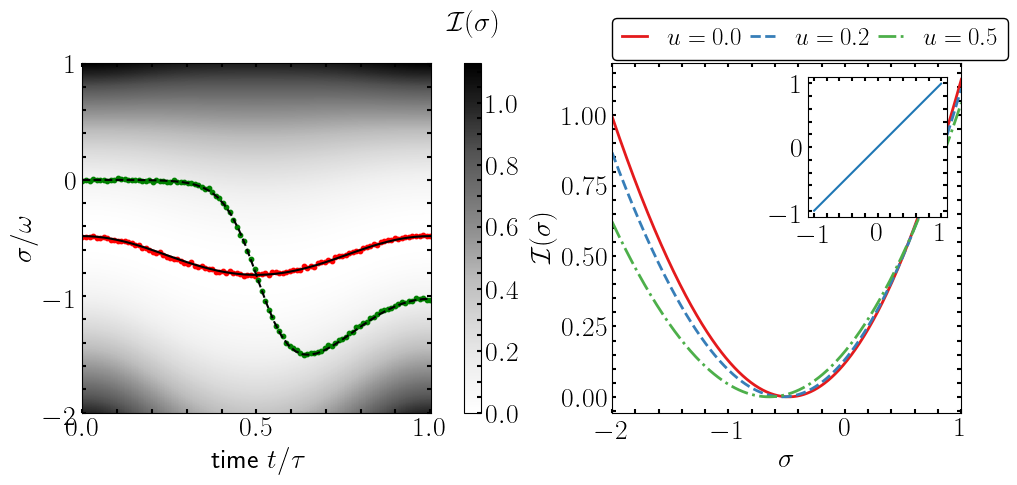

In [13]:

K, T = np.meshgrid(klist, tlist)


# Plot the original function and its Legendre transform
fig, ax = plt.subplots(1,2, figsize=(10, 5), 
                       layout='compressed')


cbar = ax[0].pcolormesh(T, K, np.array(phi).real, cmap="Greys",rasterized=True)
cbar1 = fig.colorbar(cbar, ax=ax[0], pad=.05, fraction=0.05,  orientation='vertical')
cbar1.ax.set_xlabel(r"$\mathcal{I}(\sigma)$", labelpad=-290, va='top')



ax[0].set_xlabel(r"time $t/\tau$")
ax[0].set_ylabel(r"$\sigma/\omega$")

#ax[0].scatter(np.arange(1000-1)/(1000-1), mean_values[1:], s=1, c="red")

#ax[0].plot(tlist, kmin_list, color="black" )

ax[0].scatter(data_s0["Nboxes"], data_s0["ent"], color="red", s=10)
ax[0].plot(data_s0["tlist"], data_s0["SCFG_prediction"], color="black")

ax[0].scatter(data_st["Nboxes"], data_st["ent"], color="green", s=10)
ax[0].plot(data_st["tlist"], data_st["SCFG_prediction"], color="black", linestyle="--")

ax[0].set_box_aspect(1)

######


ax[1].plot(klist, np.array(phi).real[0],
           label=r"$u = 0.0$", color="#e41a1c", linewidth=2)

ax[1].plot(klist, np.array(phi).real[25]
          , label=r"$u = 0.2$", linewidth=2, linestyle="--",color="#377eb8")

ax[1].plot(klist, np.array(phi).real[49]
          , label=r"$u = 0.5$", linewidth=2, linestyle="-.", color="#4daf4a")


ax[1].set_box_aspect(1)

ax[1].set_xlabel(r"$\sigma$")
ax[1].set_ylabel(r"$\mathcal{I}(\sigma)$")

ax[1].legend(edgecolor="black", 
             framealpha=1,
             handlelength=1,
             borderpad=0.4, 
             loc=(0,1.01),
             ncol=3,
             columnspacing=0.3,
             fontsize=18)

inset_ax = inset_axes(ax[1], width="40%", height="40%", loc=1)  # loc=2 specifies the upper left corner
inset_ax.plot(new_activity, new_phi-np.flip(new_phi))

ax[1].set_xlim((-2, 1))

#plt.savefig("entropy_prod.pdf")
